# Analyzing GDC Data Using GA4GH DOS

In this demonstration we will use a [dos-gdc-lambda](https://github.com/DataBiosphere/dos-gdc-lambda/) to access data using GA4GH compliant methods. There is a wealth of public data available for analysis let's see what we get!

## Getting a listing of data

Using the GA4GH client we can quickly get a listing of available data objects.

In [2]:
from ga4gh.dos.client import Client
local_client = Client('https://dos-gdc.ucsc-cgp-dev.org/', config={'validate_responses': False})
client = local_client.client
models = local_client.models
ListDataObjectsRequest = models.get_model('ListDataObjectsRequest')
list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=100, page_token="2"))
list_response = list_request.result()
print("Number of Data Objects: {} ".format(len(list_response.data_objects)))

Number of Data Objects: 100 


### Iterating to get a larger portion of the index

Data from GDC are returned following the GA4GH page_size. However, we would like to retrieve more and so pmap function to grab many pages in parallel.

In [3]:
data_objects = []
page_token = None

from pmap.core import pmap

def list_data_objects(page):
    list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=100, page_token=str(100*page)))
    list_response = list_request.result()
    page_token = list_response.next_page_token
    return list_response.data_objects

%time data_objects = list(pmap(list_data_objects, range(1000), threads=16))

CPU times: user 24.5 s, sys: 5.02 s, total: 29.5 s
Wall time: 46.7 s


In [4]:
data_objects = reduce(lambda x, y: x + y, data_objects)
len(data_objects)

100000

## Visualizing summary data

These data, indexed by the GDC API, are being made available to the GA4GH client using a lambda function which dynamically creates an interoperability layer.

Let's start by looking at a histogram of the file sizes represented in the portion of the GDC data requested. We'll set the y-axis to log since there are a lot of very small files and a few very large ones.

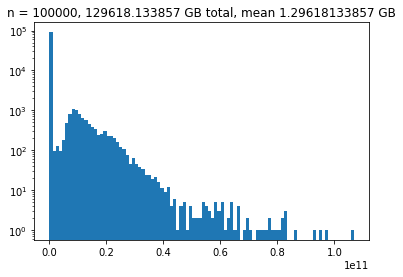

In [21]:
import matplotlib.pyplot as plt
file_sizes = [float(x.size) for x in data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('log')
plt.show()

## Filtering for public data

Currently, we rely on metadata from GDC to reason about the access controls on data. We'll also look at the overall picture of these file sizes.

In [22]:
public_data_objects = filter(
    lambda x: x['urls'][0]['system_metadata']['access'] == 'open', 
    data_objects)
print('Number of public Data Objects: {}'.format(len(public_data_objects)))

Number of public Data Objects: 41291


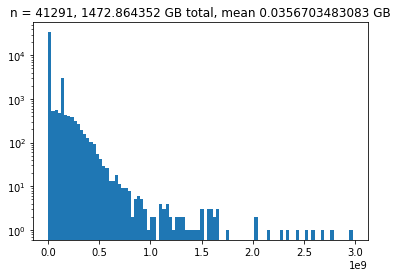

In [23]:
file_sizes = [float(x.size) for x in public_data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('log')
plt.show()

Note that we can see immediately that most of the public data are small files, under 100MB.

## Analyzing data from DOS

Counts from data are considerable non-identifiable and public. They let us understand the variety of tumors that exist in this case.

In [24]:
public_htseq_counts = filter(
    lambda x: x.name.endswith('.htseq.counts.gz'), 
    public_data_objects)

In [25]:
len(public_htseq_counts)

2959

In [26]:
[x.name for x in public_htseq_counts][0:10]

[u'6fc4ab63-6afc-4de5-a774-2ae0badb4f55.htseq.counts.gz',
 u'79f11db1-6893-410f-8fbb-8da2a54d0957.htseq.counts.gz',
 u'21e95e8f-574f-4d95-b2dd-5312e91dcc67.htseq.counts.gz',
 u'16c25e30-6e3d-401c-90c3-053af280fbb2.htseq.counts.gz',
 u'eaee0d82-cd7e-47a5-859f-59b7bf5ad6a0.htseq.counts.gz',
 u'6d60eab2-3b0a-4c35-9fc2-f4c8b7c5b894.htseq.counts.gz',
 u'7ea3830a-0961-4f23-9de1-5a658dcf46bd.htseq.counts.gz',
 u'4a9bb3fd-4e75-4585-82f7-7254889b9838.htseq.counts.gz',
 u'ced61cfd-4e64-48da-a5c1-bf6d4f68f889.htseq.counts.gz',
 u'0011596d-cfa3-48f7-b182-b1e5765209fc.htseq.counts.gz']

We can now download these files in order to analyze them locally using a few simple functions.

In [27]:
import gzip
def unzip_file(zipped, unzipped):
    with open(unzipped, 'wb') as f:
        with gzip.open(zipped, 'rb') as z:
            f.write(z.read())

import requests
def download_file(url, filename):
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return filename

def download_unzip(do):
    download_file(do.urls[0].url, do.name)
    unzip_file(do.name, do.name.replace('.gz', ''))



In [28]:
download_unzip(public_htseq_counts[0])

We can then load this file and parse it using available means.

## Loading data directly into pandas

`pandas` proves useful when handling tabular data and we can use it here to gather compressed data directly into a dataframe in memory. This reduces the need for disk space.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(
    public_htseq_counts[1].urls[0].url,
    sep='\t',
    compression='gzip',
    names=['feature', 'count'])

In [ ]:
df.hist(bins=1000)
plt.yscale('log')
plt.xlim(0, 1000000)
plt.show()

## Performing a meta-analysis

Now that we are able to gather reasonable looking counts, we can perform a meta-analysis. Here we will look at the information content of each sample.

In [68]:
from skimage.measure import shannon_entropy as se
import numpy as np

In [69]:
se(np.array([x.count for x in list(df.itertuples())]))

10.182270675940829

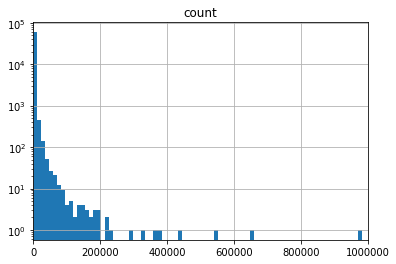

10.0480847028


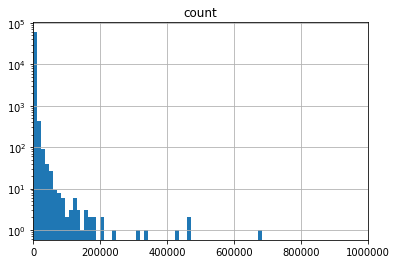

10.1822706759


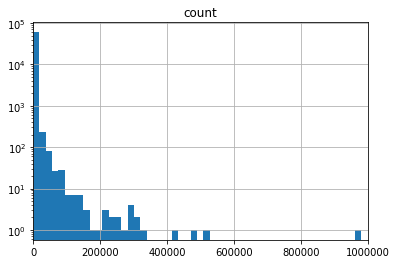

9.67927593081


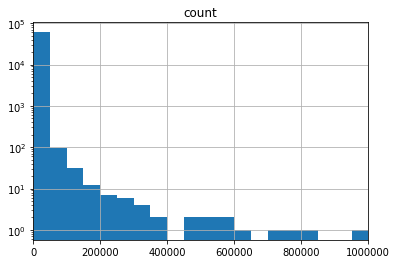

8.10808068953


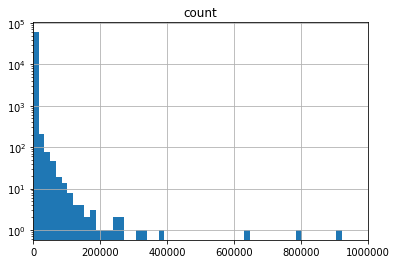

9.38894976141


In [70]:
entropies = []
for sample in public_htseq_counts[:5]:
    sampledf = pd.read_csv(
        sample.urls[0].url,
        sep='\t',
        compression='gzip',
        names=['feature', 'count'])
    sampledf.hist(bins=1000)
    plt.yscale('log')
    plt.xlim(0, 1000000)
    plt.show()
    entropy = se(np.array([x.count for x in list(sampledf.itertuples())]))
    print(entropy)
    entropies.append(entropy)

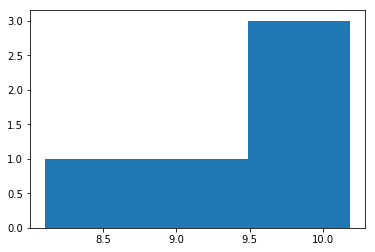

In [71]:
plt.hist(entropies, bins=3)
plt.show()

In [ ]:
matrix = []
count = 0

def load_samples(sample):
    try:
        sampledf = pd.read_csv(
            sample.urls[0].url,
            sep='\t',
            compression='gzip',
            names=['feature', 'count'])
    except Exception as e:
        print(sample.urls[0].url)
    return [x.count for x in list(sampledf.itertuples())]

%time matrix = list(pmap(load_samples, public_htseq_counts, threads=32))


In [ ]:
len(matrix)

In [ ]:
from sklearn.decomposition import PCA
pca_values = PCA(n_components=5).fit_transform(matrix)

In [ ]:
plt.title('pca_5 0_1 htseq_counts, c=entropy')
plt.scatter([x[0] for x in pca_values], [x[1] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_2 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[2] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_3 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_4 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_0 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_2 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[2] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_3 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_4 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_0 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_1 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[1] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_3 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_4 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_0 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_1 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[1] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_2 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[2] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_4 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[4] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_0 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[0] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_1 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[1] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_2 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[2] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_3 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[3] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()

In [ ]:
from sklearn.manifold import TSNE
%time tsne_values = TSNE(n_components=2, n_iter=500).fit_transform(matrix)


In [ ]:
plt.title('tsne_2 htseq_counts, c=entropy')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=[se(np.array(x)) for x in matrix])
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
%time clusters = AgglomerativeClustering(n_clusters=12).fit_predict(pca_values)

In [ ]:
plt.title('tsne_2 htseq_counts, c=entropy')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=clusters)
plt.show()

## Entropies by cluster

In [ ]:
plt.hist([se(np.array(x)) for x in matrix])
plt.show()

In [ ]:
with_clusters = zip(clusters, matrix)

In [ ]:
entropies = []
clusters_list = []
for i in range(12):
    cluster = np.array([x[1] for x in filter(lambda x: x[0] == i, with_clusters)])
    clusters_list.append(cluster)
    entropies.append(se(cluster))


In [ ]:
plt.hist(entropies, bins=5)
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
%time distances = pairwise_distances(matrix[0:1500])

In [ ]:
plt.imshow(distances)
plt.show()

In [ ]:
%time distances = pairwise_distances(clusters_list[0])


In [ ]:
for i, cluster in enumerate(clusters_list):
    plt.title('Pairwise distance within cluster {}'.format(i))
    plt.imshow(pairwise_distances(cluster))
    plt.show()

In [ ]:
cluster_ordered = [x for x in clusters_list[0]] + \
    [x for x in clusters_list[1]] + \
    [x for x in clusters_list[2]] + \
    [x for x in clusters_list[3]] + \
    [x for x in clusters_list[4]] + \
    [x for x in clusters_list[5]] + \
    [x for x in clusters_list[6]] + \
    [x for x in clusters_list[7]] + \
    [x for x in clusters_list[8]] + \
    [x for x in clusters_list[9]] + \
    [x for x in clusters_list[10]] + \
    [x for x in clusters_list[11]]

In [ ]:
plt.title('Pairwise distance cluster ordered')
plt.imshow(pairwise_distances(cluster_ordered[0:1500]))
plt.show()

In [ ]:
means = [np.mean(x) for x in matrix]

In [ ]:
plt.title('Mean total expression')
plt.hist(means)
plt.show()

In [ ]:
plt.title('tsne_2 c=means')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=means)
plt.show()

In [ ]:
plt.title('tsne_2 s=entropy c=means')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], s=[se(np.array(x)) for x in matrix], c=means)
plt.show()

In [ ]:
#%matplotlib notebook


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], [x[1] for x in pca_values], c=means, marker='o', s=0.3)
plt.show()

In [ ]:
%time tsne3_values = TSNE(n_components=3, n_iter=500).fit_transform(matrix)


In [ ]:

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
%time clusters = AgglomerativeClustering(n_clusters=7).fit_predict(tsne3_values)
with_clusters = 
ax.scatter([x[0] for x in tsne3_values], [x[1] for x in tsne3_values], [x[2] for x in tsne3_values], c=clusters, marker='o', s=0.3)
plt.show()

In [ ]:
from scipy.spatial import ConvexHull
clusters_list = []
with_clusters = zip(clusters, tsne3_values)
for i in range(7):
    cluster = np.array([x[1] for x in filter(lambda x: x[0] == i, with_clusters)])
    clusters_list.append(cluster)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
ax.scatter([x[0] for x in tsne3_values], [x[1] for x in tsne3_values], [x[2] for x in tsne3_values], c=clusters, marker='o', s=0.3)
for i in range(7):
    ax.plot_trisurf([x[0] for x in clusters_list[i]], [x[1] for x in clusters_list[i]], [x[2] for x in clusters_list[i]], color=colors[i])
plt.title('tsne3 with concave hull per cluster')
plt.show()